In [1]:
## Set-up.
### Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
! pip freeze > '../requirements.txt'

In [2]:
DATA_PATH = '../dataset/'

In [3]:
data = pd.read_parquet(os.path.join(DATA_PATH,'data_eng.gzip'))

In [4]:
data.head()

,age,gender,education,class,marital_status,race,is_hispanic,employment_commitment,employment_stat,wage_per_hour,working_week_per_year,industry_code_main,occupation_code_main,household_summary,vet_benefit,tax_status,citizenship,income_above_limit,investments
0,63+,Female,highschool,NA,Widowed,White,No,Unemployed,0,0_10,weeks_worked_48_52,Not in universe or children,NA,Householder,2,Head of household,Native,0,True
1,63+,Female,highschool,NA,Widowed,White,No,Children or Armed Forces,0,0_10,weeks_worked_0,Not in universe or children,NA,Householder,2,Single,Native,0,False
2,18_24,Male,no_highschool,Federal government,Never married,Black,No,Children or Armed Forces,0,101_500,weeks_worked_1_25,Hospital services,Adm support including clerical,Child 18 or older,2,Single,Native,0,False
4,63+,Male,highschool,NA,Married-civilian spouse present,White,No,Unemployed,0,0_10,weeks_worked_0,Not in universe or children,NA,Spouse of householder,2,Joint both 65+,Native,0,False
5,33_45,Male,bachelors,Private,Married-civilian spouse present,Asian or Pacific Islander,No,Children or Armed Forces,0,501_1000,weeks_worked_48_52,Retail trade,Other service,Householder,2,Joint both under 65,Foreign born- Not a citizen of U S,0,False


## Drop columns with potential discrimination

In [5]:
drop_col = ['gender','race','is_hispanic']
data = data.drop(drop_col, axis=1)

In [6]:
data.head()

,age,education,class,marital_status,employment_commitment,employment_stat,wage_per_hour,working_week_per_year,industry_code_main,occupation_code_main,household_summary,vet_benefit,tax_status,citizenship,income_above_limit,investments
0,63+,highschool,NA,Widowed,Unemployed,0,0_10,weeks_worked_48_52,Not in universe or children,NA,Householder,2,Head of household,Native,0,True
1,63+,highschool,NA,Widowed,Children or Armed Forces,0,0_10,weeks_worked_0,Not in universe or children,NA,Householder,2,Single,Native,0,False
2,18_24,no_highschool,Federal government,Never married,Children or Armed Forces,0,101_500,weeks_worked_1_25,Hospital services,Adm support including clerical,Child 18 or older,2,Single,Native,0,False
4,63+,highschool,NA,Married-civilian spouse present,Unemployed,0,0_10,weeks_worked_0,Not in universe or children,NA,Spouse of householder,2,Joint both 65+,Native,0,False
5,33_45,bachelors,Private,Married-civilian spouse present,Children or Armed Forces,0,501_1000,weeks_worked_48_52,Retail trade,Other service,Householder,2,Joint both under 65,Foreign born- Not a citizen of U S,0,False


In [7]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('income_above_limit', axis=1), data['income_above_limit'], test_size=0.3, random_state=12345)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = Pipeline(
    steps=[
        ('impute',SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown="ignore"))
        ]
)

In [10]:
X_tr_pr = preprocessor.fit_transform(X_train)

In [11]:
X_tst_pr = preprocessor.transform(X_test)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score as ROC

def dmp_first_classifier(model, train_x, train_y, test_x, test_y, parameters ={}):
    classifier = model()
    if len(parameters.items())>0:
        searcher = GridSearchCV(classifier, parameters, cv=5)
        searcher.fit(train_x, train_y)
        print(f'Model {model}')
        print("Best CV params", searcher.best_params_)
        #print("Test accuracy of best grid search hypers:", searcher.score(test_x, test_y))
        best_model = searcher.best_estimator_
    else: best_model = classifier
    best_model.fit(train_x, train_y)
    print("Test accuracy of best grid search hypers:", best_model.score(test_x, test_y))
    return best_model

def train_accuracy(model, train_x, train_y, test_x, test_y):
    model.fit(train_x, train_y)
    print("Test accuracy:", model.score(test_x, test_y))
    return model

In [13]:
from sklearn.linear_model import LogisticRegression
lrg = LogisticRegression
parameters = {'C':[0.01,0.1,1]}
best_lrg = dmp_first_classifier(lrg, X_tr_pr, y_train, X_tst_pr, y_test, parameters)

Model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Best CV params {'C': 0.1}
Test accuracy of best grid search hypers: 0.9297389230021647


In [14]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier
parameters = {'n_neighbors':[5,10,50]}
best_knc = dmp_first_classifier(knc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)

Model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Best CV params {'n_neighbors': 50}
Test accuracy of best grid search hypers: 0.9276847638821398


In [16]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier
parameters = {'criterion':['gini','log_loss'],'min_samples_leaf':[1,5,10,20,30]}
best_dtc = dmp_first_classifier(dtc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)

Model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Best CV params {'criterion': 'log_loss', 'min_samples_leaf': 30}
Test accuracy of best grid search hypers: 0.927287184697619


In [17]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier
parameters = {'loss':['hinge','log_loss']}
best_sgdc = dmp_first_classifier(sgdc, X_tr_pr, y_train, X_tst_pr, y_test, parameters)


Model <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
Best CV params {'loss': 'log_loss'}
Test accuracy of best grid search hypers: 0.9307107832309935


### Score TOP-3

In [18]:
from sklearn import metrics

def score_model(model, X, y):
    predicted = model.predict(X)
    probs = model.predict_proba(X)
    
    # Generate and display different evaluation metrics
    print(metrics.accuracy_score(y, predicted))
    print(metrics.roc_auc_score(y, probs[:, 1]))
    
    print(metrics.confusion_matrix(y, predicted))
    print(metrics.classification_report(y, predicted))

In [19]:
score_model(best_sgdc, X_tst_pr, y_test)

0.9307107832309935
0.9085002416132468
[[40587   844]
 [ 2293  1550]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     41431
           1       0.65      0.40      0.50      3843

    accuracy                           0.93     45274
   macro avg       0.80      0.69      0.73     45274
weighted avg       0.92      0.93      0.92     45274


In [20]:
score_model(best_lrg, X_tst_pr, y_test)

0.9297389230021647
0.9090868412317743
[[40817   614]
 [ 2567  1276]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     41431
           1       0.68      0.33      0.45      3843

    accuracy                           0.93     45274
   macro avg       0.81      0.66      0.70     45274
weighted avg       0.92      0.93      0.92     45274


In [21]:
score_model(best_dtc, X_tst_pr, y_test)

0.927287184697619
0.8761042856522958
[[40770   661]
 [ 2631  1212]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     41431
           1       0.65      0.32      0.42      3843

    accuracy                           0.93     45274
   macro avg       0.79      0.65      0.69     45274
weighted avg       0.91      0.93      0.92     45274


In [22]:
score_model(best_knc, X_tst_pr, y_test)

0.9276847638821398
0.8946353769739759
[[40897   534]
 [ 2740  1103]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     41431
           1       0.67      0.29      0.40      3843

    accuracy                           0.93     45274
   macro avg       0.81      0.64      0.68     45274
weighted avg       0.91      0.93      0.91     45274


## Upsampling

In [23]:
upsample_training = X_train.copy()
upsample_training['Y'] = y_train

In [24]:
bellow = upsample_training.loc[upsample_training.Y==0]
above = upsample_training.loc[upsample_training.Y==1]

In [25]:
from sklearn.utils import resample
above_upsample = resample(above,
             replace=True,
             n_samples=len(bellow),
             random_state=12345)

In [26]:
print(bellow.shape)
print(above_upsample.shape)

(96485, 16)
(96485, 16)


In [27]:
data_upsample = pd.concat([bellow, above_upsample])
data_upsample.head()

,age,education,class,marital_status,employment_commitment,employment_stat,wage_per_hour,working_week_per_year,industry_code_main,occupation_code_main,household_summary,vet_benefit,tax_status,citizenship,investments,Y
87286,63+,masters,NA,Never married,Children or Armed Forces,0,0_10,weeks_worked_0,Not in universe or children,NA,Householder,2,Single,Native,False,0
78624,46_62,highschool,NA,Married-civilian spouse present,Children or Armed Forces,0,0_10,weeks_worked_0,Not in universe or children,NA,Spouse of householder,2,Joint one under 65 & one 65+,Native,False,0
2842,63+,no_highschool,NA,Married-civilian spouse present,Unemployed,0,0_10,weeks_worked_0,Not in universe or children,NA,Householder,2,Joint both 65+,Native,False,0
88532,46_62,highschool,Private,Never married,Full-time schedules,2,0_10,weeks_worked_48_52,Retail trade,Adm support including clerical,Child 18 or older,2,Single,Native,False,0
10009,46_62,somecollege,Private,Divorced,Children or Armed Forces,0,0_10,weeks_worked_48_52,Social services,Professional specialty,Householder,2,Head of household,Native,False,0


In [28]:
X_train_up = data_upsample.drop('Y', axis=1)
y_train_up = data_upsample.Y

In [29]:
X_train_up_pr = preprocessor.fit_transform(X_train_up)
X_tst_up_pr = preprocessor.transform(X_test)

In [30]:
from sklearn.linear_model import LogisticRegression
lrg = LogisticRegression
parameters = {'C':[0.01,0.1,1]}
best_lrg_up = dmp_first_classifier(lrg, X_train_up_pr, y_train_up, X_tst_up_pr, y_test, parameters)

Model <class 'sklearn.linear_model._logistic.LogisticRegression'>
Best CV params {'C': 0.1}
Test accuracy of best grid search hypers: 0.8238945089897071


In [31]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier
parameters = {'loss':['hinge','log_loss']}
best_sgdc_up = dmp_first_classifier(sgdc, X_train_up_pr, y_train_up, X_tst_up_pr, y_test, parameters)


Model <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
Best CV params {'loss': 'log_loss'}
Test accuracy of best grid search hypers: 0.8225250695763573


In [32]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier
parameters = {'criterion':['gini','log_loss'],'min_samples_leaf':[1,5,10,20]}
best_dtc_up = dmp_first_classifier(dtc, X_train_up_pr, y_train_up, X_tst_up_pr, y_test, parameters)

Model <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Best CV params {'criterion': 'gini', 'min_samples_leaf': 1}
Test accuracy of best grid search hypers: 0.8719795025842647


In [36]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier
parameters = {'n_neighbors':[5,10,50]}
best_knc_up = dmp_first_classifier(knc, X_train_up_pr, y_train_up, X_tst_up_pr, y_test, parameters)

Model <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Best CV params {'n_neighbors': 5}
Test accuracy of best grid search hypers: 0.9044263815876662


## The best models with upscaling

In [37]:
score_model(best_dtc_up, X_tst_up_pr, y_test)

0.8719795025842647
0.6973322454503689
[[37567  3864]
 [ 1932  1911]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     41431
           1       0.33      0.50      0.40      3843

    accuracy                           0.87     45274
   macro avg       0.64      0.70      0.66     45274
weighted avg       0.90      0.87      0.88     45274


In [42]:
score_model(best_sgdc_up, X_tst_up_pr, y_test)

0.8225250695763573
0.9087978311025835
[[33992  7439]
 [  596  3247]]
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     41431
           1       0.30      0.84      0.45      3843

    accuracy                           0.82     45274
   macro avg       0.64      0.83      0.67     45274
weighted avg       0.93      0.82      0.86     45274


In [39]:
score_model(best_lrg_up, X_tst_up_pr, y_test)

0.8238945089897071
0.9091941962851962
[[34059  7372]
 [  601  3242]]
              precision    recall  f1-score   support

           0       0.98      0.82      0.90     41431
           1       0.31      0.84      0.45      3843

    accuracy                           0.82     45274
   macro avg       0.64      0.83      0.67     45274
weighted avg       0.93      0.82      0.86     45274


In [44]:
score_model(best_knc_up, X_tst_up_pr, y_test)

0.9044263815876662
0.6953995938420368
[[39604  1827]
 [ 2500  1343]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     41431
           1       0.42      0.35      0.38      3843

    accuracy                           0.90     45274
   macro avg       0.68      0.65      0.67     45274
weighted avg       0.90      0.90      0.90     45274


## Compair with best models without upscaling

In [41]:
score_model(best_sgdc, X_tst_pr, y_test)

0.9307107832309935
0.9085002416132468
[[40587   844]
 [ 2293  1550]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     41431
           1       0.65      0.40      0.50      3843

    accuracy                           0.93     45274
   macro avg       0.80      0.69      0.73     45274
weighted avg       0.92      0.93      0.92     45274


In [45]:
import pickle
# save the model to disk
filename = 'prod_model_lrg_up.pkl'
pickle.dump(best_lrg_up, open(filename, 'wb'))

In [46]:
# save the model to disk
filename = 'prod_model_sgdc.pkl'
pickle.dump(best_sgdc, open(filename, 'wb'))

In [47]:
y_score = best_sgdc.predict_proba(X_tst_pr)

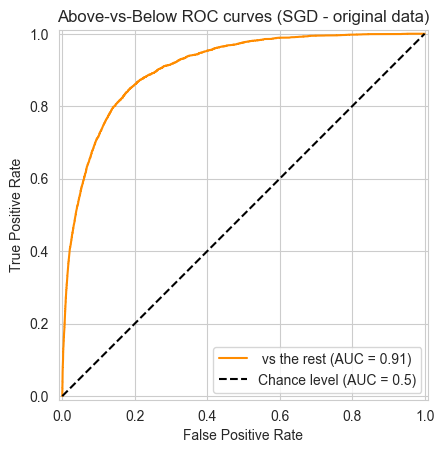

In [49]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_test[:],
    y_score[:,1],
    name=f" vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Above-vs-Below ROC curves (SGD - original data)",
)

In [51]:
y_score_up = best_lrg_up.predict_proba(X_tst_up_pr)

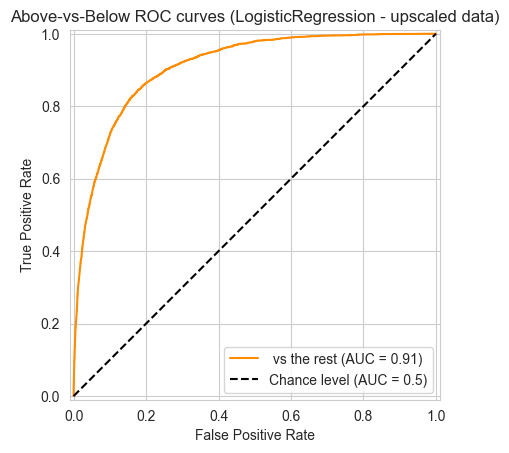

In [52]:
display = RocCurveDisplay.from_predictions(
    y_test[:],
    y_score_up[:,1],
    name=f" vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Above-vs-Below ROC curves (LogisticRegression - upscaled data)",
)